In [1]:
import torch
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# Setting random seeds
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### Loading dataset

In [3]:
men_paths = glob.glob('faces/man/*')
women_paths = glob.glob('faces/woman/*')
men_df = pd.DataFrame({"filepath": men_paths, "gender": 'man'})
women_df = pd.DataFrame({"filepath": women_paths, "gender": 'woman'})

raw_df = pd.concat([men_df, women_df], ignore_index=True)

In [4]:
raw_df.head()

,filepath,gender
0,faces/man/man_14711.jpg,man
1,faces/man/man_12537.jpg,man
2,faces/man/man_8040.jpg,man
3,faces/man/man_16504.jpg,man
4,faces/man/man_11950.jpg,man


In [5]:
def show_images(df, n=20, sample=False, start_row=0, preds=[]):
    df = df[start_row:]
    n = min(df.shape[0], n)
    n_rows = math.ceil(n/5)
    df = df.sample(n) if sample else df.head(n)

    fig = plt.figure(figsize=(20, 4*n_rows))

    for i, (img_index, row) in enumerate(df.iterrows()):
        optional_prediction = "\n"
        if 'prediction' in row:
            predicted_gender = "man" if row.prediction >= 0.5 else "woman"
            certainty = row.prediction if predicted_gender == "man" else 1-row.prediction
            optional_prediction += f"Prediction: {predicted_gender} - {certainty:.1%}"
        title = f"ID:{img_index} {row.gender}{optional_prediction}"
        image = Image.open(row.filepath)
        fig.add_subplot(n_rows, 5, i+1)
        plt.title(title)
        plt.imshow(image)
        plt.axis(False)
    plt.show()

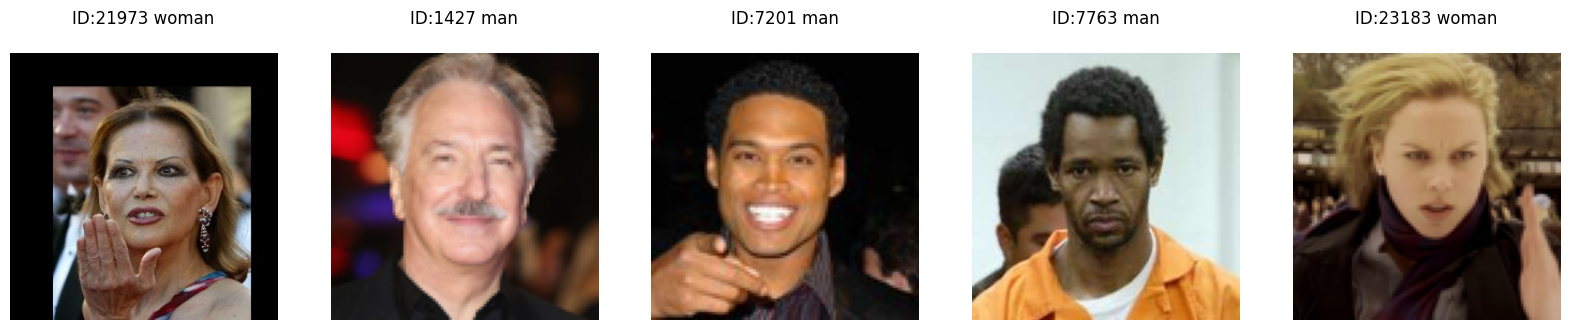

In [6]:
show_images(df=raw_df, n=5, sample=True, start_row=0)

### Evaluating image sizes

In [7]:
raw_df["shape"] = raw_df.filepath.apply(lambda x: np.array(Image.open(x)).shape)

In [8]:
shape_count = raw_df["shape"].value_counts().apply(lambda x: f'{x/len(raw_df)*100 :.2f}%')
shape_count

shape
(250, 250, 3)     48.70%
(100, 100, 3)     42.81%
(147, 113, 3)      0.01%
(146, 106, 3)      0.01%
(86, 67, 3)        0.01%
                   ...  
(716, 499, 3)      0.00%
(337, 270, 3)      0.00%
(1208, 911, 3)     0.00%
(255, 195, 3)      0.00%
(416, 334, 3)      0.00%
Name: count, Length: 2127, dtype: object

Let's use only the two most common sizes of the dataset. We're still going to have a lot of images to work with. Their dimensions are close to 299x299, so they won't be distorted upon resizing.

In [9]:
filtered_df = raw_df[(raw_df["shape"] == (250, 250, 3)) | (raw_df["shape"] == (100, 100, 3))]

In [10]:
filtered_df.shape

(24860, 3)

### Evaluating class distribution

<Axes: xlabel='count', ylabel='gender'>

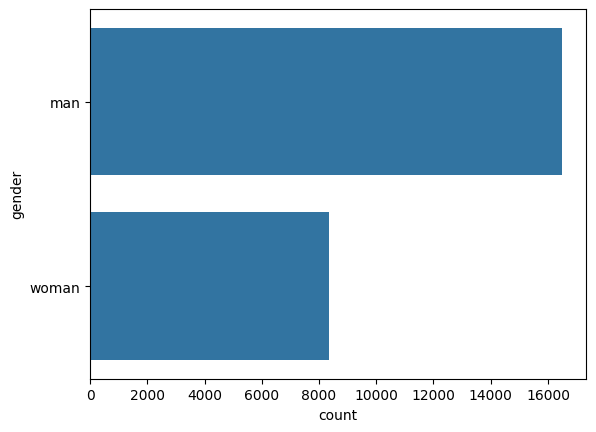

In [11]:
sns.countplot(filtered_df['gender'])

In [12]:
df = filtered_df.copy()
df = df.groupby('gender')
df = df.apply(lambda x: x.sample(df.size().min())).reset_index(drop=True)
df.gender.value_counts()

gender
man      8355
woman    8355
Name: count, dtype: int64

In [13]:
# We'll save the dataset to a .csv file so we can load it in another script
df.to_csv('faces.csv', index=False)